In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
products = pd.read_csv('data/products.csv')
waferProjections = pd.read_csv('data/waferProjections.csv')

Given these two datasets, we will be attempting to forecast Sulfuric Acid usage for the next two weeks.

In [5]:
display(waferProjections)
products

,Wk1,Wk2,Wk3,Wk4,Wk5,Wk6,Wk7,Wk8,Wk9,Wk10
A,3289,3566,2358,2951,2152,973,2453,2314,2347,2765
B,2100,2409,4090,1874,3893,3973,3615,3541,2900,2602


,BatchLife,LoadSize
A,5-7,35-38
B,7-8,45-52


Handling Ranges:

We have a number of parameters which are not values but ranges of values. Handling them is a difficult task. We will be creating a functions that process the data at different stages. We will first test these functions on week 1 and then use on the rest.

In [7]:
# Week 1 Values
wafers_a = 3289
wafers_b = 2100

min_load_a = 35
max_load_a = 38
min_load_b = 45
max_load_b = 52

# Step 1: Find the number of batches that can be produced using the wafers.
def wafers_to_batchs(waf, min_load, max_load):
    # Load is a range so need account for both ends
    min_batch = np.floor(waf/max_load)
    max_batch = np.floor(waf/min_load)

    return min_batch, max_batch

batches_a = wafers_to_batchs(wafers_a,min_load_a,max_load_a)
batches_b = wafers_to_batchs(wafers_b,min_load_b,max_load_b)

# get the range of total batches we will get
total_batches_min = batches_a[0] + batches_b[0]
total_batches_max = batches_a[1] + batches_b[1]

total_batches_min, total_batches_max


(126.0, 139.0)

In [8]:
# Calculate how many hours each batch will take given 168 hours per week of operation
batch_duration_min = 168/total_batches_min
batch_duration_max = 168/total_batches_max

batch_duration_min, batch_duration_max

(1.3333333333333333, 1.20863309352518)

In [9]:
# Batch Life 

batch_life_min_a = 5
batch_life_max_a = 7

batch_life_min_b = 7
batch_life_max_b = 8

In [36]:
reclaimed_percent = 0.04

# Assume product A is finished completely before product B is used
# later need find a way to overcome this limitation


# Minimum batches first 
amtSolution = 0
prev = 0 
timing = 0

for i in range(int(batches_a[0])):
    if timing >= 8.3 or i % batch_life_min_a == 0:
        needed = 80 - (reclaimed_percent * prev)
        amtSolution += needed 
        prev = 80
        timing = 0 
    timing += batch_duration_min

prev = 0 
timing = 0

for i in range(int(batches_b[0])):
    if timing >= 8.3 or i % batch_life_min_b == 0:
        needed = 80 - (reclaimed_percent * prev)
        amtSolution += needed 
        prev = 80
        timing = 0 
    timing += batch_duration_min

In [54]:
chemicalLife = 500/60

# later switch arnd and see how
MeanBatchLifeTimeA = 1/2 * ((batch_life_min_a * batch_duration_min) + (batch_life_min_a * batch_duration_max))
MeanBatchLifeTimeB = 1/2 * ((batch_life_min_b * batch_duration_min) + (batch_life_min_b * batch_duration_max))


In [55]:
BatchTillChemicalMin = chemicalLife / batch_duration_max
BatchTillChemicalMax = chemicalLife / batch_duration_min

In [56]:
ALimitingFactor = False if MeanBatchLifeTimeA < chemicalLife else True
BLimitingFactor = False if MeanBatchLifeTimeB < chemicalLife else True

In [57]:
H2SO4MinA = np.ceil(batches_a[0] / batch_life_max_a) if ALimitingFactor else np.ceil(batches_a[0] / BatchTillChemicalMax)
H2SO4MaxA = np.ceil(batches_a[1] / batch_life_min_a) if ALimitingFactor  else np.ceil(batches_a[1] / BatchTillChemicalMin)

H2SO4MinB = np.ceil(batches_b[0] / batch_life_max_b) if BLimitingFactor else np.ceil(batches_b[0]  / BatchTillChemicalMax)
H2SO4MaxB = np.ceil(batches_b[1]  / batch_life_min_b) if BLimitingFactor else np.ceil(batches_b[1]  / BatchTillChemicalMin)


In [58]:
H2SO4TotalMin = H2SO4MinA + H2SO4MinB
H2SO4TotalMax = H2SO4MaxA + H2SO4MaxB

# Calculate the amount of Sulphuric Acid required in litres given the reclaim efficiency
H2SO4TotalMinLitres = 80 + (H2SO4TotalMin - 1) * 80 * (1 - 0.09)
H2SO4TotalMaxLitres = 80 + (H2SO4TotalMax - 1) * 80 * (1 - 0.04)

In [59]:
H2SO4TotalMinLitres, H2SO4TotalMaxLitres

(1390.4, 1616.0)

In [37]:
amtSolution

1849.5999999999995

# Key parameters

- Batch Life
- Reclaim Percentage
- Load Size

In [137]:
def get_sulfur(wafers_a, wafers_b, load_a, load_b, reclaim, batch_life_a, batch_life_b):
    batches_a = np.floor(wafers_a/load_a)
    batches_b = np.floor(wafers_b/load_b)

    batch_duration = 168/(batches_a+batches_b)
    
    amtSolution = 0
    prev = 0 
    timing = 0

    for i in range(int(batches_a)):
        if timing >= 8.3 or i % batch_life_a == 0:
            needed = 80 - (reclaim * prev)
            amtSolution += needed 
            prev = 80
            timing=0
        timing += batch_duration

    prev = 0 
    timing = 0

    for i in range(int(batches_b)):
        if timing >= 8.3 or i % batch_life_b == 0:
            needed = 80 - (reclaim * prev)
            amtSolution += needed 
            prev = 80
            timing = 0
        timing += batch_duration
    
    return amtSolution

In [78]:
def get_sulfur(wafers_a, wafers_b, load_a, load_b, reclaim, batch_life_a, batch_life_b):
    batches_a = np.floor(wafers_a/load_a)
    batches_b = np.floor(wafers_b/load_b)

    batch_duration = 168/(batches_a+batches_b)
    chemicalLife = 500/60

    MeanBatchLifeTimeA = batch_life_b * batch_duration
    MeanBatchLifeTimeB = batch_life_a * batch_duration

    BatchTillChemical = chemicalLife / batch_duration

    ALimitingFactor = 'Chemical' if MeanBatchLifeTimeA < chemicalLife else "Batch"
    BLimitingFactor = 'Chemical' if MeanBatchLifeTimeB < chemicalLife else "Batch"

    H2SO4_a = np.ceil(batches_a / batch_life_a) if ALimitingFactor == "Batch" else np.ceil(batches_a / BatchTillChemical)
    H2SO4_b = np.ceil(batches_b / batch_life_b) if BLimitingFactor == "Batch" else np.ceil(batches_b / BatchTillChemical)

    H2SO4TotalLitres = 80 + ((H2SO4_b+H2SO4_a) - 1) * 80 * (1 - reclaim)

    return H2SO4TotalLitres

In [138]:
get_sulfur(3289,2100,38,52,0.04, 5, 7)

1849.5999999999995

In [70]:
load_a = [35,36,37,38]
load_b = [45,46,47,48,49,50,51,52]

reclaim = np.arange(0.04,0.09,0.01)

batch_life_a = [5,6,7]
batch_life_b = [7,8]

In [71]:
list(product(load_a, load_b, reclaim, batch_life_a, batch_life_b))

[(35, 45, 0.04, 5, 7),
 (35, 45, 0.04, 5, 8),
 (35, 45, 0.04, 6, 7),
 (35, 45, 0.04, 6, 8),
 (35, 45, 0.04, 7, 7),
 (35, 45, 0.04, 7, 8),
 (35, 45, 0.05, 5, 7),
 (35, 45, 0.05, 5, 8),
 (35, 45, 0.05, 6, 7),
 (35, 45, 0.05, 6, 8),
 (35, 45, 0.05, 7, 7),
 (35, 45, 0.05, 7, 8),
 (35, 45, 0.060000000000000005, 5, 7),
 (35, 45, 0.060000000000000005, 5, 8),
 (35, 45, 0.060000000000000005, 6, 7),
 (35, 45, 0.060000000000000005, 6, 8),
 (35, 45, 0.060000000000000005, 7, 7),
 (35, 45, 0.060000000000000005, 7, 8),
 (35, 45, 0.07, 5, 7),
 (35, 45, 0.07, 5, 8),
 (35, 45, 0.07, 6, 7),
 (35, 45, 0.07, 6, 8),
 (35, 45, 0.07, 7, 7),
 (35, 45, 0.07, 7, 8),
 (35, 45, 0.08000000000000002, 5, 7),
 (35, 45, 0.08000000000000002, 5, 8),
 (35, 45, 0.08000000000000002, 6, 7),
 (35, 45, 0.08000000000000002, 6, 8),
 (35, 45, 0.08000000000000002, 7, 7),
 (35, 45, 0.08000000000000002, 7, 8),
 (35, 46, 0.04, 5, 7),
 (35, 46, 0.04, 5, 8),
 (35, 46, 0.04, 6, 7),
 (35, 46, 0.04, 6, 8),
 (35, 46, 0.04, 7, 7),
 (35, 46,

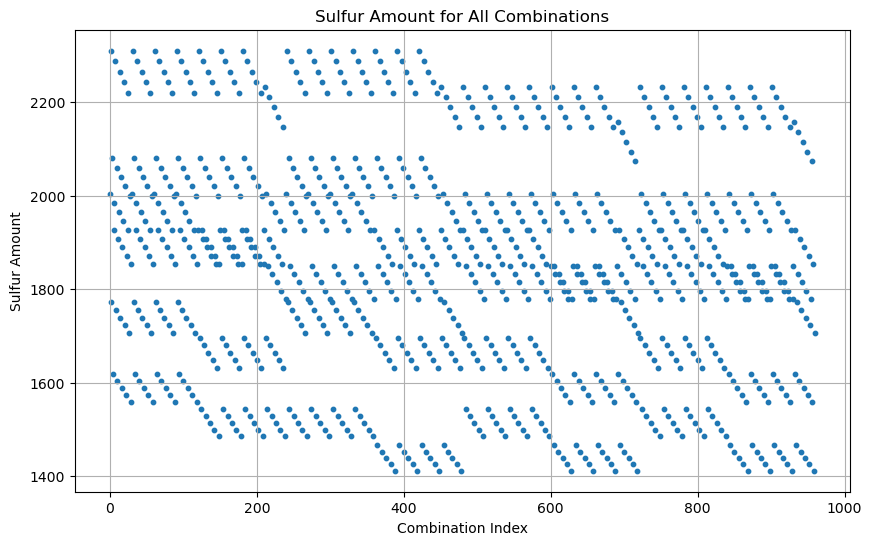

In [139]:
results = []

for params in product(load_a, load_b, reclaim, batch_life_a, batch_life_b):
    sulfur = get_sulfur(3289, 2100, *params)
    results.append(sulfur)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(results)), results, s=10)
plt.xlabel('Combination Index')
plt.ylabel('Sulfur Amount')
plt.title('Sulfur Amount for All Combinations')
plt.grid(True)
plt.show()

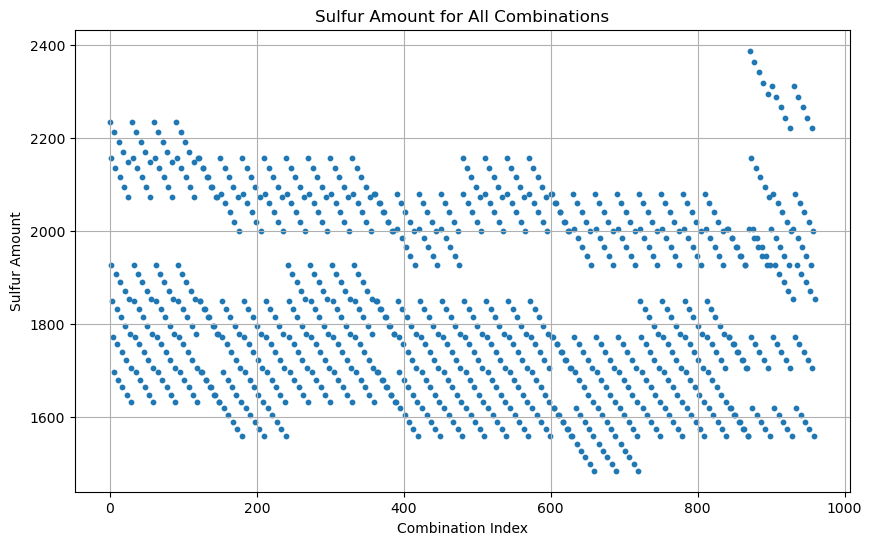

In [140]:
results = []

for params in product(load_a, load_b, reclaim, batch_life_a, batch_life_b):
    sulfur = get_sulfur(3566, 2409, *params)
    results.append(sulfur)

plt.figure(figsize=(10, 6))
plt.scatter(range(len(results)), results, s=10)
plt.xlabel('Combination Index')
plt.ylabel('Sulfur Amount')
plt.title('Sulfur Amount for All Combinations')
plt.grid(True)
plt.show()

In [141]:
sum(results)/len(results)

1837.9

In [142]:
## Getting the forecasts
def getForecast(wafers_a,wafers_b):
    results = []

    for params in product(load_a, load_b, reclaim, batch_life_a, batch_life_b):
        sulfur = get_sulfur(wafers_a, wafers_b, *params)
        results.append(sulfur)
    return sum(results)/len(results)


In [148]:
res = {}
for col in waferProjections.columns:
    week_values = waferProjections[col].tolist()
    week_forecast = getForecast(*week_values)
    res[col] = round(week_forecast,1)
    print(f"Forecast for {col}: {week_forecast}")
print(res)
display(pd.DataFrame([res]))

Forecast for Wk1: 1847.3
Forecast for Wk2: 1837.9
Forecast for Wk3: 1761.9166666666665
Forecast for Wk4: 2026.6833333333334
Forecast for Wk5: 1880.9833333333331
Forecast for Wk6: 2103.8416666666667
Forecast for Wk7: 1839.075
Forecast for Wk8: 1897.041666666667
Forecast for Wk9: 1910.7500000000002
Forecast for Wk10: 1814.4
{'Wk1': 1847.3, 'Wk2': 1837.9, 'Wk3': 1761.9, 'Wk4': 2026.7, 'Wk5': 1881.0, 'Wk6': 2103.8, 'Wk7': 1839.1, 'Wk8': 1897.0, 'Wk9': 1910.8, 'Wk10': 1814.4}


,Wk1,Wk2,Wk3,Wk4,Wk5,Wk6,Wk7,Wk8,Wk9,Wk10
0,1847.3,1837.9,1761.9,2026.7,1881.0,2103.8,1839.1,1897.0,1910.8,1814.4


In [82]:
results

[1616.0,
 2153.6,
 1616.0,
 1846.3999999999999,
 1616.0,
 1692.8,
 1600.0,
 2132.0,
 1600.0,
 1828.0,
 1600.0,
 1676.0,
 1584.0,
 2110.3999999999996,
 1584.0,
 1809.6,
 1584.0,
 1659.1999999999998,
 1568.0,
 2088.8,
 1568.0,
 1791.1999999999998,
 1568.0,
 1642.3999999999999,
 1552.0,
 2067.2,
 1552.0,
 1772.8,
 1552.0,
 1625.6,
 1616.0,
 2153.6,
 1616.0,
 1846.3999999999999,
 1616.0,
 1692.8,
 1600.0,
 2132.0,
 1600.0,
 1828.0,
 1600.0,
 1676.0,
 1584.0,
 2110.3999999999996,
 1584.0,
 1809.6,
 1584.0,
 1659.1999999999998,
 1568.0,
 2088.8,
 1568.0,
 1791.1999999999998,
 1568.0,
 1642.3999999999999,
 1552.0,
 2067.2,
 1552.0,
 1772.8,
 1552.0,
 1625.6,
 1616.0,
 2153.6,
 1616.0,
 1846.3999999999999,
 1616.0,
 1692.8,
 1600.0,
 2132.0,
 1600.0,
 1828.0,
 1600.0,
 1676.0,
 1584.0,
 2110.3999999999996,
 1584.0,
 1809.6,
 1584.0,
 1659.1999999999998,
 1568.0,
 2088.8,
 1568.0,
 1791.1999999999998,
 1568.0,
 1642.3999999999999,
 1552.0,
 2067.2,
 1552.0,
 1772.8,
 1552.0,
 1625.6,
 1616.0,
 

In [83]:
list(product(load_a, load_b, reclaim, batch_life_a, batch_life_b))

[(35, 45, 0.04, 5, 7),
 (35, 45, 0.04, 5, 8),
 (35, 45, 0.04, 6, 7),
 (35, 45, 0.04, 6, 8),
 (35, 45, 0.04, 7, 7),
 (35, 45, 0.04, 7, 8),
 (35, 45, 0.05, 5, 7),
 (35, 45, 0.05, 5, 8),
 (35, 45, 0.05, 6, 7),
 (35, 45, 0.05, 6, 8),
 (35, 45, 0.05, 7, 7),
 (35, 45, 0.05, 7, 8),
 (35, 45, 0.060000000000000005, 5, 7),
 (35, 45, 0.060000000000000005, 5, 8),
 (35, 45, 0.060000000000000005, 6, 7),
 (35, 45, 0.060000000000000005, 6, 8),
 (35, 45, 0.060000000000000005, 7, 7),
 (35, 45, 0.060000000000000005, 7, 8),
 (35, 45, 0.07, 5, 7),
 (35, 45, 0.07, 5, 8),
 (35, 45, 0.07, 6, 7),
 (35, 45, 0.07, 6, 8),
 (35, 45, 0.07, 7, 7),
 (35, 45, 0.07, 7, 8),
 (35, 45, 0.08000000000000002, 5, 7),
 (35, 45, 0.08000000000000002, 5, 8),
 (35, 45, 0.08000000000000002, 6, 7),
 (35, 45, 0.08000000000000002, 6, 8),
 (35, 45, 0.08000000000000002, 7, 7),
 (35, 45, 0.08000000000000002, 7, 8),
 (35, 46, 0.04, 5, 7),
 (35, 46, 0.04, 5, 8),
 (35, 46, 0.04, 6, 7),
 (35, 46, 0.04, 6, 8),
 (35, 46, 0.04, 7, 7),
 (35, 46,

In [129]:
absolute_errors = [abs(number - 1686) for number in results]

combinations = list(zip(absolute_errors,list(product(load_a, load_b, reclaim, batch_life_a, batch_life_b))))

In [130]:
sorted_array = sorted(combinations, key=lambda x: x[0])

sorted_array

[(6.0, (35, 49, 0.05, 6, 7)),
 (6.0, (35, 50, 0.05, 6, 7)),
 (6.0, (35, 51, 0.05, 6, 7)),
 (6.0, (35, 52, 0.05, 6, 7)),
 (6.0, (36, 49, 0.05, 6, 7)),
 (6.0, (36, 50, 0.05, 6, 7)),
 (6.0, (36, 51, 0.05, 6, 7)),
 (6.0, (36, 52, 0.05, 6, 7)),
 (6.0, (37, 45, 0.05, 6, 7)),
 (6.0, (37, 46, 0.05, 6, 7)),
 (6.0, (37, 47, 0.05, 6, 7)),
 (6.0, (37, 48, 0.05, 6, 7)),
 (6.0, (38, 45, 0.05, 6, 7)),
 (6.0, (38, 46, 0.05, 6, 7)),
 (6.0, (38, 47, 0.05, 6, 7)),
 (6.0, (38, 48, 0.05, 6, 7)),
 (9.999999999999545, (35, 49, 0.04, 6, 7)),
 (9.999999999999545, (35, 50, 0.04, 6, 7)),
 (9.999999999999545, (35, 51, 0.04, 6, 7)),
 (9.999999999999545, (35, 52, 0.04, 6, 7)),
 (9.999999999999545, (36, 49, 0.04, 6, 7)),
 (9.999999999999545, (36, 50, 0.04, 6, 7)),
 (9.999999999999545, (36, 51, 0.04, 6, 7)),
 (9.999999999999545, (36, 52, 0.04, 6, 7)),
 (9.999999999999545, (37, 45, 0.04, 6, 7)),
 (9.999999999999545, (37, 46, 0.04, 6, 7)),
 (9.999999999999545, (37, 47, 0.04, 6, 7)),
 (9.999999999999545, (37, 48, 0.04, 

In [96]:
sorted_array[:10]

[(6.7999999999999545, (35, 45, 0.04, 7, 8)),
 (6.7999999999999545, (35, 46, 0.04, 7, 8)),
 (6.7999999999999545, (35, 47, 0.04, 7, 8)),
 (6.7999999999999545, (35, 48, 0.04, 7, 8)),
 (6.7999999999999545, (35, 49, 0.04, 7, 8)),
 (6.7999999999999545, (35, 50, 0.04, 7, 8)),
 (6.7999999999999545, (35, 51, 0.04, 7, 8)),
 (6.7999999999999545, (35, 52, 0.04, 7, 8)),
 (6.7999999999999545, (36, 45, 0.04, 5, 7)),
 (6.7999999999999545, (36, 45, 0.04, 6, 7))]

In [131]:
def get_top_combi(wafers_a, wafers_b, actual, n=10):
    for params in product(load_a, load_b, reclaim, batch_life_a, batch_life_b):
        sulfur = get_sulfur(wafers_a, wafers_b, *params)
        results.append(sulfur)
    absolute_errors = [abs(number - actual) for number in results]
    
    combinations = list(zip(absolute_errors,list(product(load_a, load_b, reclaim, batch_life_a, batch_life_b))))
    sorted_array = sorted(combinations, key=lambda x: x[0])

    return [i for i in sorted_array[:n]]

In [132]:
get_top_combi(3566, 2409, 1686)

[(6.0, (35, 49, 0.05, 6, 7)),
 (6.0, (35, 50, 0.05, 6, 7)),
 (6.0, (35, 51, 0.05, 6, 7)),
 (6.0, (35, 52, 0.05, 6, 7)),
 (6.0, (36, 49, 0.05, 6, 7)),
 (6.0, (36, 50, 0.05, 6, 7)),
 (6.0, (36, 51, 0.05, 6, 7)),
 (6.0, (36, 52, 0.05, 6, 7)),
 (6.0, (37, 45, 0.05, 6, 7)),
 (6.0, (37, 46, 0.05, 6, 7))]

In [144]:
actualVals = [1686, 1998, 1858, 1870, 1894]

a_wafs = [3289,	3566, 2358, 2951, 2152]
b_wafs = [2100, 2409, 4090, 1874, 3893]

res = []
for i in range(5):
    print(f"Week {i+1}")
    display(get_top_combi(a_wafs[i], b_wafs[i], actualVals[i],10))

Week 1


[(6.0, (35, 45, 0.05, 7, 8)),
 (6.0, (35, 46, 0.05, 7, 8)),
 (6.0, (35, 47, 0.05, 7, 8)),
 (6.0, (35, 48, 0.05, 7, 8)),
 (6.0, (35, 49, 0.05, 7, 7)),
 (6.0, (35, 49, 0.05, 7, 8)),
 (6.0, (35, 50, 0.05, 7, 7)),
 (6.0, (35, 51, 0.05, 7, 7)),
 (6.0, (35, 52, 0.05, 7, 7)),
 (6.0, (36, 45, 0.05, 7, 8))]

Week 2


[(1.9999999999990905, (35, 50, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (35, 51, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (35, 52, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (36, 45, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (36, 46, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (36, 47, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (36, 48, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (36, 49, 0.08000000000000002, 5, 7)),
 (1.9999999999990905, (36, 49, 0.08000000000000002, 5, 8)),
 (1.9999999999990905, (36, 50, 0.08000000000000002, 5, 7))]

Week 3


[(5.200000000000728, (35, 45, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (35, 46, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (35, 47, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (35, 48, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (36, 45, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (36, 46, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (36, 47, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (36, 48, 0.08000000000000002, 6, 7)),
 (5.200000000000728, (38, 51, 0.08000000000000002, 7, 8)),
 (5.200000000000728, (38, 52, 0.08000000000000002, 7, 8))]

Week 4


[(1.2000000000007276, (35, 45, 0.07, 6, 7)),
 (1.2000000000007276, (35, 46, 0.07, 6, 7)),
 (1.2000000000007276, (35, 47, 0.07, 6, 7)),
 (1.2000000000007276, (35, 48, 0.07, 6, 7)),
 (1.2000000000007276, (36, 45, 0.07, 6, 7)),
 (1.2000000000007276, (36, 46, 0.07, 6, 7)),
 (1.2000000000007276, (36, 47, 0.07, 6, 7)),
 (1.2000000000007276, (36, 48, 0.07, 6, 7)),
 (1.2000000000007276, (38, 51, 0.07, 7, 8)),
 (1.2000000000007276, (38, 52, 0.07, 7, 8))]

Week 5


[(4.399999999999409, (35, 45, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (35, 46, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (35, 47, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (35, 48, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (36, 45, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (36, 46, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (36, 47, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (36, 48, 0.060000000000000005, 6, 7)),
 (4.399999999999409, (38, 51, 0.060000000000000005, 7, 8)),
 (4.399999999999409, (38, 52, 0.060000000000000005, 7, 8))]

Load_size of A -> Quite varied so keep 36

Load_size of B -> Quite varied so keep to 45

Reclaim -> 4%

Batch_life of A -> 6

Batch_life of B -> 8

In [154]:
res = { }
for col in waferProjections.columns:
    week_values = waferProjections[col].tolist()
    week_forecast = get_sulfur(*week_values, 35,45,0.05,6,7)
    print(f"Forecast for {col}: {week_forecast}")
    res[col] = week_forecast

print(res)
display(pd.DataFrame([res]))

Forecast for Wk1: 1756.0
Forecast for Wk2: 1908.0
Forecast for Wk3: 1908.0
Forecast for Wk4: 1528.0
Forecast for Wk5: 1832.0
Forecast for Wk6: 2288.0
Forecast for Wk7: 1832.0
Forecast for Wk8: 1756.0
Forecast for Wk9: 1680.0
Forecast for Wk10: 1756.0
{'Wk1': 1756.0, 'Wk2': 1908.0, 'Wk3': 1908.0, 'Wk4': 1528.0, 'Wk5': 1832.0, 'Wk6': 2288.0, 'Wk7': 1832.0, 'Wk8': 1756.0, 'Wk9': 1680.0, 'Wk10': 1756.0}


,Wk1,Wk2,Wk3,Wk4,Wk5,Wk6,Wk7,Wk8,Wk9,Wk10
0,1756.0,1908.0,1908.0,1528.0,1832.0,2288.0,1832.0,1756.0,1680.0,1756.0
